In [66]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import glob
import os

In [67]:
if torch.cuda.is_available():
    print(f'cuda : {torch.cuda.get_device_name(0)}')
else:
    print("not available")

cuda : NVIDIA A100-SXM4-80GB MIG 1g.10gb


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.9/609.9 kB 70.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [optuna]2m5/6 [optuna]]my]


In [68]:
import optuna

In [87]:
# --- 1. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 300
SRC_PATTERN = r'/workspace/Silent_Speech/dataset_sony/Normalized_dataset/recordings/*/*.csv'

# --- 2. SUBJECT-WISE NORMALIZATION (THE FIX) ---
print("1. Loading & Normalizing PER SUBJECT...")
files = glob.glob(SRC_PATTERN)
all_sequences, all_words, all_subjects = [], [], []
features = ["theta", "x", "y", "omega", "alpha"]

for filepath in files:
    try:
        df = pd.read_csv(filepath)
        raw_data = df[features].values
        
        # --- CRITICAL FIX START ---
        # Normalize THIS subject's data independently
        # This forces everyone's mean jaw position to be 0.
        subject_scaler = StandardScaler()
        norm_data = subject_scaler.fit_transform(raw_data)
        # --- CRITICAL FIX END ---
        
        # Chunking Logic (Same as before)
        n_chunks = len(norm_data) // T
        if n_chunks > 0:
            data_trimmed = norm_data[:n_chunks * T]
            chunks = data_trimmed.reshape(n_chunks, T, 5)
            
            all_sequences.append(chunks)
            
            # Metadata
            word = os.path.basename(os.path.dirname(filepath))
            subj = os.path.basename(filepath).replace('.csv', '')
            all_words.extend([word] * n_chunks)
            all_subjects.extend([subj] * n_chunks)
            
    except Exception as e:
        pass

# Stack
X_raw = np.vstack(all_sequences) # Shape: (1094, 300, 5)

print(f"Data Loaded. Shape: {X_raw.shape}")
print("Subject bias removed. Ready for training.")

# Create Loader
X_tensor = torch.tensor(X_raw, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

1. Loading & Normalizing PER SUBJECT...
Data Loaded. Shape: (1094, 300, 5)
Subject bias removed. Ready for training.


In [79]:
# --- 3. RE-INITIALIZE MODEL ---
# (We must reset weights to avoid "bad gradients" from the failed run)
class KinematicAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim, num_layers, T):
        super(KinematicAutoencoder, self).__init__()
        self.T = T
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.bottleneck = nn.Linear(hidden_size, latent_dim)
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_size)
        self.decoder_lstm = nn.LSTM(hidden_size, input_size, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        latent = self.bottleneck(h_n[-1]) 
        z = self.latent_to_hidden(latent).unsqueeze(1).repeat(1, self.T, 1)
        recon, _ = self.decoder_lstm(z)
        return recon, latent

print("3. Training Model...")
# Using your previous best params
model = KinematicAutoencoder(5, hidden_size=64, latent_dim=128, num_layers=1, T=300).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()

3. Training Model...


In [80]:
# --- 2. UPDATED OPTUNA OBJECTIVE ---
def objective(trial):
    # Hyperparameters
    latent_dim = trial.suggest_categorical("latent_dim", [32, 64, 128])
    hidden_size = trial.suggest_int("hidden_size", 64, 256, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 3) # <--- Added Layers
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    
    model = KinematicAutoencoder(
        input_size=5, 
        hidden_size=hidden_size,
        latent_dim=latent_dim, 
        num_layers=num_layers,
        T=300
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(30): # Short runs for tuning
        model.train()
        total_loss = 0
        for x_batch in train_loader: # Assuming train_loader is defined globally or passed
            x_batch = x_batch[0].to(device)
            optimizer.zero_grad()
            reconstructed, _ = model(x_batch)
            
            loss = criterion(reconstructed, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        trial.report(avg_loss, epoch)
        if trial.should_prune(): raise optuna.exceptions.TrialPruned()

    return avg_loss

In [81]:
# Training Loop
for epoch in range(30):
    model.train()
    total_loss = 0
    for x_batch, in train_loader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        recon, _ = model(x_batch)
        loss = criterion(recon, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 5 == 0:
        print(f"   Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

   Epoch 5: Loss = 1.0077
   Epoch 10: Loss = 0.9680
   Epoch 15: Loss = 0.9705
   Epoch 20: Loss = 0.9933
   Epoch 25: Loss = 0.9731
   Epoch 30: Loss = 0.9704


4. Extracting Features...
   Extracted Shape: (1094, 128)
   Running t-SNE with perplexity=30...


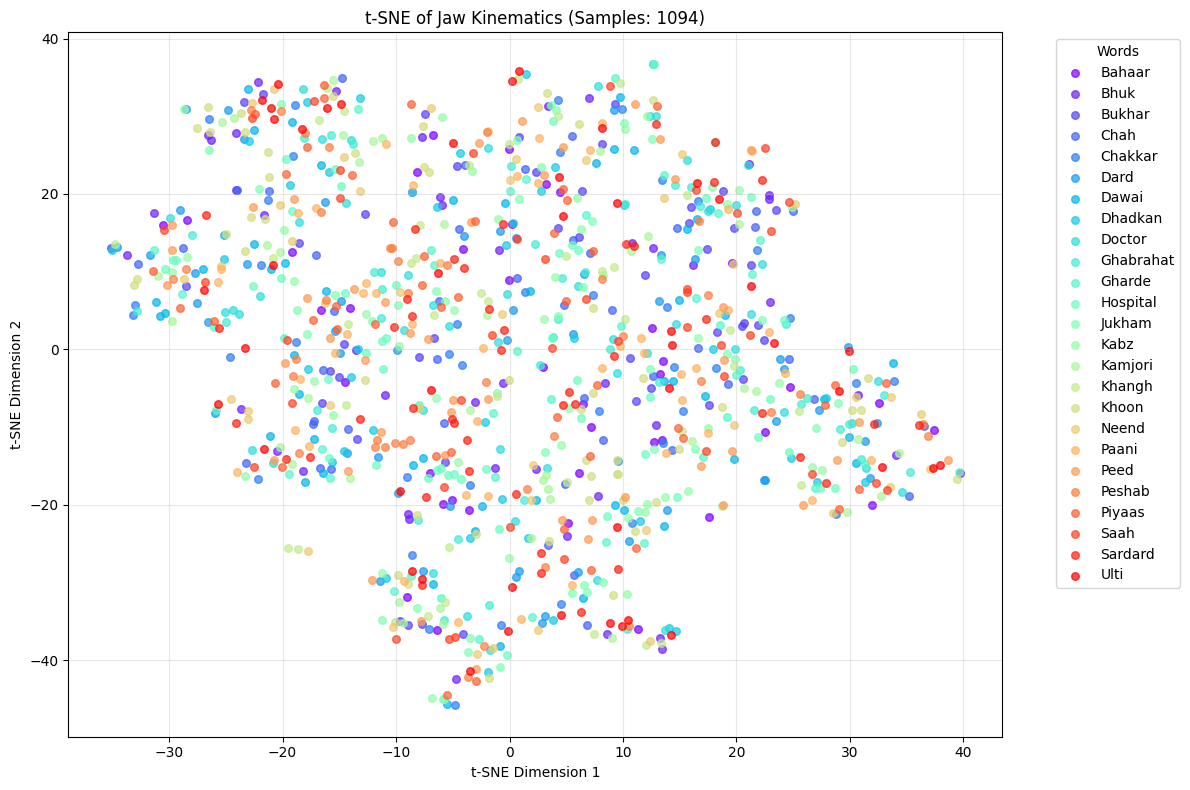

In [83]:
# --- 4. EXTRACT & VISUALIZE ---
print("4. Extracting Features...")
model.eval()
latents = []

with torch.no_grad():
    # shuffle=False is CRITICAL to match features with all_words labels
    extract_loader = DataLoader(dataset, batch_size=64, shuffle=False) 
    for x_batch, in extract_loader:
        _, z = model(x_batch.to(device))
        latents.append(z.cpu().numpy())

# FIX: Stack the list of arrays into one big array
features = np.vstack(latents) 

print(f"   Extracted Shape: {features.shape}") 
# Expected shape: (1094, 128) or similar. 
# If this prints (5, 128), you are still using the old data loader.

# --- t-SNE ---
# Dynamic perplexity to avoid errors if sample size is small
n_samples = features.shape[0]
perp = min(30, max(1, n_samples - 1))

print(f"   Running t-SNE with perplexity={perp}...")
tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
z_2d = tsne.fit_transform(features)

# --- PLOTTING ---
plt.figure(figsize=(12, 8))

# Ensure labels match the data size 
# (In case some files were skipped during loading, we slice labels to match)
current_labels = np.array(all_words)[:n_samples]
unique_words = np.unique(current_labels)

# Generate a distinct color for each word
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_words)))

for word, color in zip(unique_words, colors):
    idx = (current_labels == word)
    plt.scatter(z_2d[idx, 0], z_2d[idx, 1], label=word, s=30, alpha=0.7, color=color)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, title="Words")
plt.title(f"t-SNE of Jaw Kinematics (Samples: {n_samples})")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

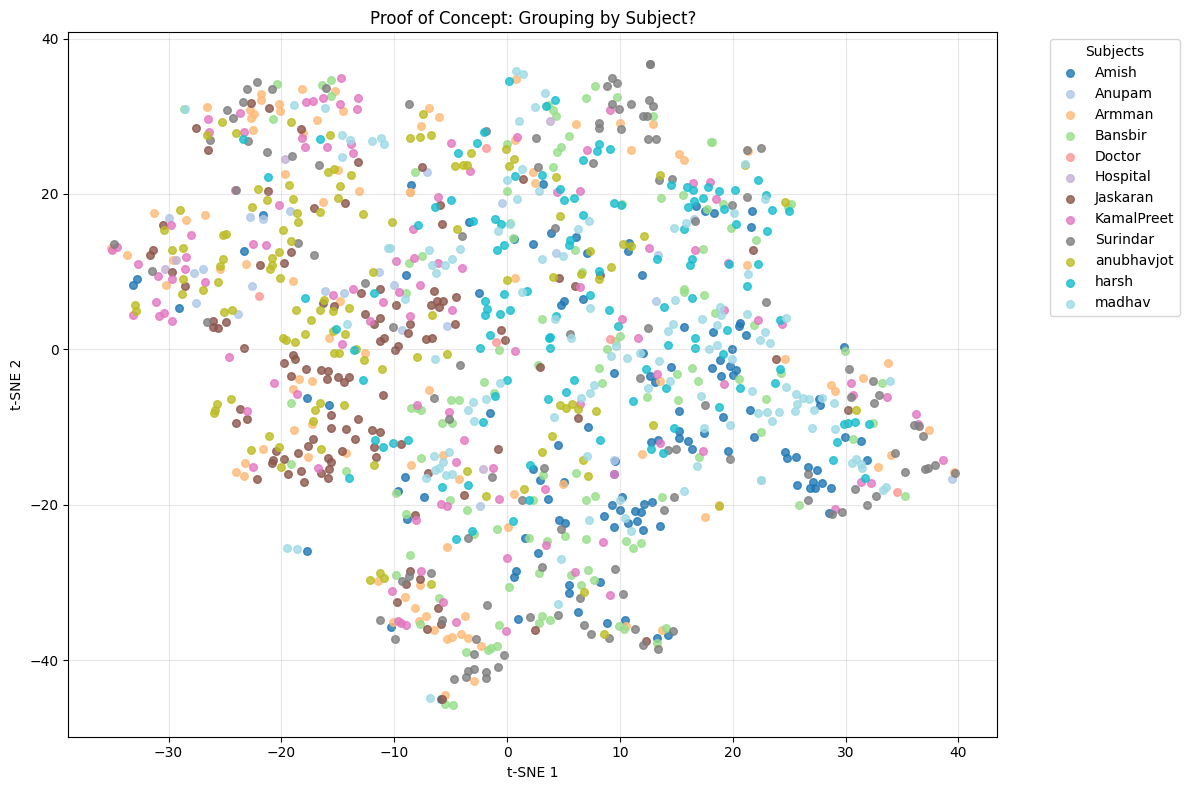

In [84]:
# --- PROOF: COLOR BY SUBJECT ---
plt.figure(figsize=(12, 8))

# Get unique subjects from your metadata list
unique_subjects = np.unique(all_subjects)
# Create distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_subjects)))

for subj, color in zip(unique_subjects, colors):
    # Boolean mask: Select only points belonging to this subject
    idx = (np.array(all_subjects)[:n_samples] == subj)
    
    # Plot them
    plt.scatter(z_2d[idx, 0], z_2d[idx, 1], label=subj, s=30, alpha=0.8, color=color)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subjects")
plt.title("Proof of Concept: Grouping by Subject?")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

In [85]:
from sklearn.metrics import silhouette_score

# 1. Score based on WORDS (What we want)
score_word = silhouette_score(features, np.array(all_words)[:n_samples])
print(f"Clustering Score (Words): {score_word:.4f}")

# 2. Score based on SUBJECTS (What we suspect)
score_subj = silhouette_score(features, np.array(all_subjects)[:n_samples])
print(f"Clustering Score (Subjects): {score_subj:.4f}")

# INTERPRETATION:
# If Score(Subjects) >> Score(Words), your model is primarily identifying people.

Clustering Score (Words): -0.1700
Clustering Score (Subjects): -0.1710


Encoding labels...
Classes found: 25
Training Classifier...
Epoch 10 | Loss: 3.1523 | Train Acc: 7.20%
Epoch 20 | Loss: 3.0849 | Train Acc: 9.37%
Epoch 30 | Loss: 2.9104 | Train Acc: 13.26%
Epoch 40 | Loss: 2.8672 | Train Acc: 14.74%
Epoch 50 | Loss: 2.4279 | Train Acc: 23.54%
Epoch 60 | Loss: 2.0139 | Train Acc: 39.43%
Epoch 70 | Loss: 1.6216 | Train Acc: 50.97%
Epoch 80 | Loss: 1.2520 | Train Acc: 62.51%
Epoch 90 | Loss: 0.8559 | Train Acc: 75.20%
Epoch 100 | Loss: 0.5891 | Train Acc: 84.80%
Extracting Supervised Features...


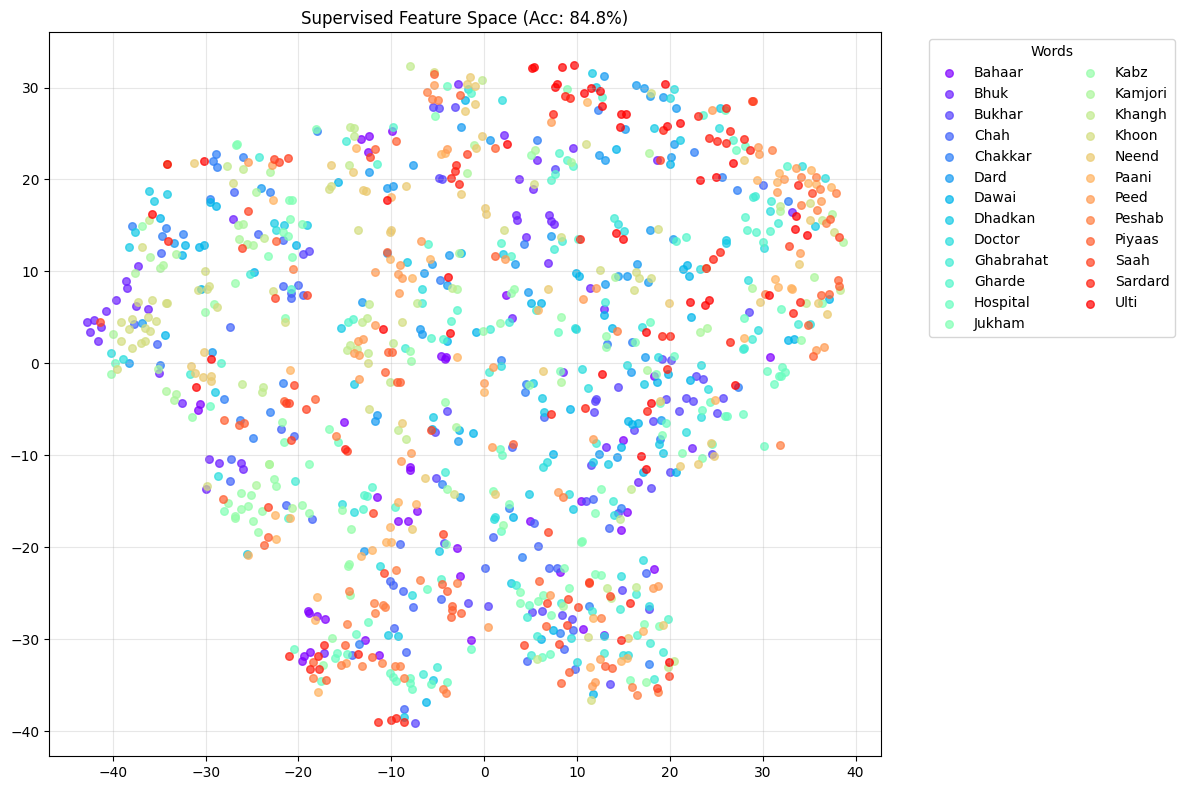

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, random_split

# --- 1. DATA PREP WITH LABELS ---
# We reuse the X_raw (1094, 300, 5) you already loaded.
# But now we encode the string labels into numbers (0, 1, 2...)
print("Encoding labels...")
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(all_words) # Strings -> Ints
num_classes = len(np.unique(y_numeric))

print(f"Classes found: {num_classes}")

# Convert to Tensors
X_tensor = torch.tensor(X_raw, dtype=torch.float32)
y_tensor = torch.tensor(y_numeric, dtype=torch.long) # Labels are strictly Long

# Create Train/Val Split (Critical for classification)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# --- 2. THE NEW MODEL (CLASSIFIER) ---
class KinematicClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(KinematicClassifier, self).__init__()
        
        # 1. Feature Extractor (The LSTM)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=0.3)
        
        # 2. The "Bottleneck" (The Features we want to plot)
        # We project the LSTM output to a smaller space (e.g., 64) before classifying
        self.bottleneck = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        
        # 3. The Classifier Head
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # LSTM Output
        _, (h_n, _) = self.lstm(x)
        lstm_feat = h_n[-1] # Take last layer's hidden state
        
        # Extract Latent Features
        latent = self.bottleneck(lstm_feat)
        latent_act = self.relu(latent)
        
        # Predict Word
        logits = self.classifier(latent_act)
        
        return logits, latent # Return BOTH predictions and features

# --- 3. TRAINING LOOP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KinematicClassifier(input_size=5, hidden_size=128, num_layers=2, 
                            num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Classifier...")
loss_history = []

for epoch in range(100): # 50 Epochs should be enough
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(x_batch) # Ignore features during training
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    acc = 100 * correct / total
    loss_history.append(total_loss / len(train_loader))
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss_history[-1]:.4f} | Train Acc: {acc:.2f}%")

# --- 4. VISUALIZE THE LEARNED FEATURES ---
print("Extracting Supervised Features...")
model.eval()
latents = []
labels = []

# Extract from ALL data (Train + Val) to see full clusters
full_loader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for x_batch, y_batch in full_loader:
        _, z = model(x_batch.to(device))
        latents.append(z.cpu().numpy())
        labels.append(y_batch.numpy())

features = np.vstack(latents)
labels_flat = np.concatenate(labels)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
z_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(12, 8))
unique_labels = np.unique(labels_flat)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label_id, color in zip(unique_labels, colors):
    idx = (labels_flat == label_id)
    word_name = label_encoder.inverse_transform([label_id])[0]
    plt.scatter(z_2d[idx, 0], z_2d[idx, 1], label=word_name, s=30, alpha=0.7, color=color)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, title="Words")
plt.title(f"Supervised Feature Space (Acc: {acc:.1f}%)")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

In [90]:
!pip install seaborn

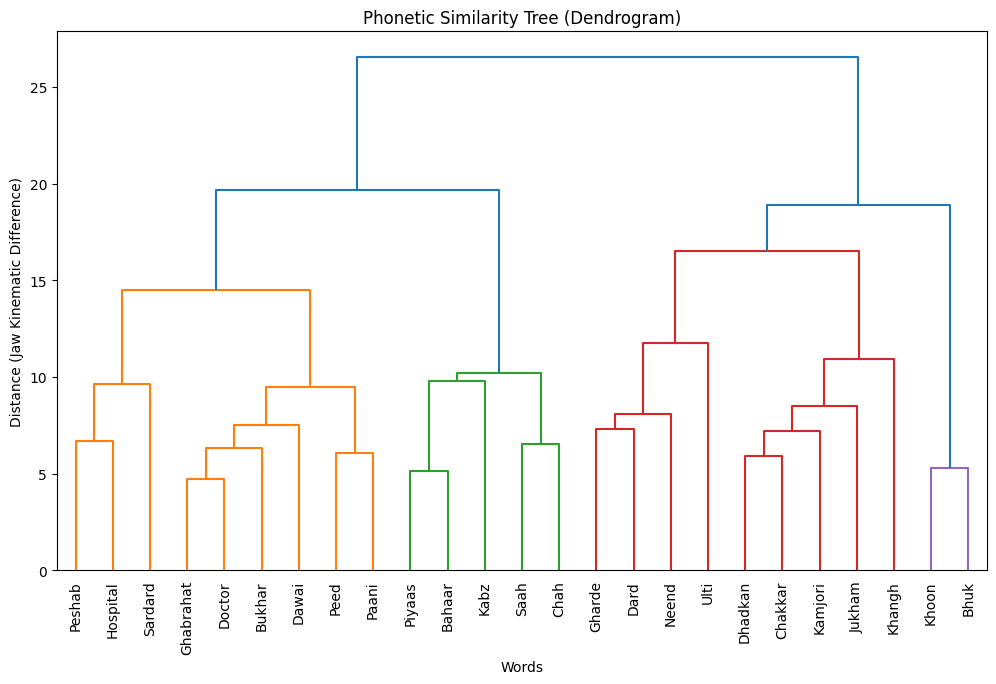

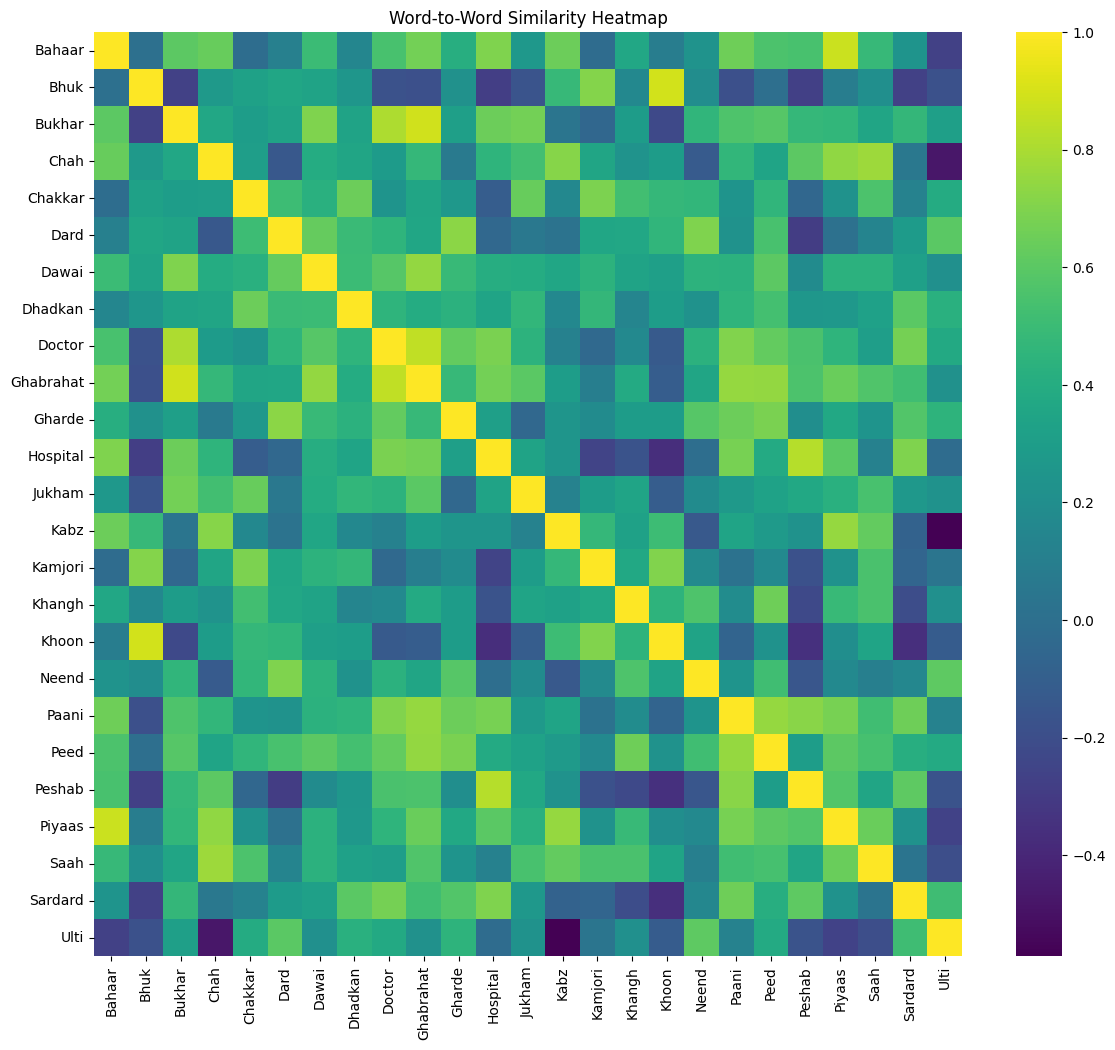

In [91]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. COMPUTE CENTROIDS (The "Essence" of each word) ---
unique_words = np.unique(labels_flat)
centroids = []
word_names = []

for label in unique_words:
    # Find all samples for this word
    indices = (labels_flat == label)
    word_features = features[indices]
    
    # Calculate the AVERAGE vector (Centroid)
    centroid = np.mean(word_features, axis=0)
    centroids.append(centroid)
    
    # Decode label to string name
    name = label_encoder.inverse_transform([label])[0]
    word_names.append(name)

centroids = np.array(centroids) # Shape: (25, 64)

# --- 2. HIERARCHICAL CLUSTERING (The Tree) ---
# We use 'ward' linkage to minimize variance within clusters
linked = linkage(centroids, 'ward')

plt.figure(figsize=(12, 7))
dendrogram(linked,
            orientation='top',
            labels=word_names,
            distance_sort='descending',
            show_leaf_counts=True)

plt.title('Phonetic Similarity Tree (Dendrogram)')
plt.ylabel('Distance (Jaw Kinematic Difference)')
plt.xlabel('Words')
plt.xticks(rotation=90)
plt.show()

# --- 3. SIMILARITY MATRIX (The Heatmap) ---
# This shows exactly HOW similar "Peed" is to "Neend" (0 to 1 score)
similarity_matrix = cosine_similarity(centroids)
df_sim = pd.DataFrame(similarity_matrix, index=word_names, columns=word_names)

plt.figure(figsize=(14, 12))
sns.heatmap(df_sim, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("Word-to-Word Similarity Heatmap")
plt.show()

1. Loading & Normalizing Data...
   Loaded 1094 sequences.
   Classes: 25
2. Initializing Research Model...
3. Training with Center Loss...
   Epoch 10 | Loss: 3.0399 | Acc: 24.00%
   Epoch 20 | Loss: 2.4461 | Acc: 42.29%
   Epoch 30 | Loss: 1.9169 | Acc: 56.00%
   Epoch 40 | Loss: 1.5989 | Acc: 61.71%
   Epoch 50 | Loss: 1.2991 | Acc: 72.57%
   Epoch 60 | Loss: 0.8786 | Acc: 86.63%
4. Generating Research Plots...


<Figure size 1200x1200 with 0 Axes>

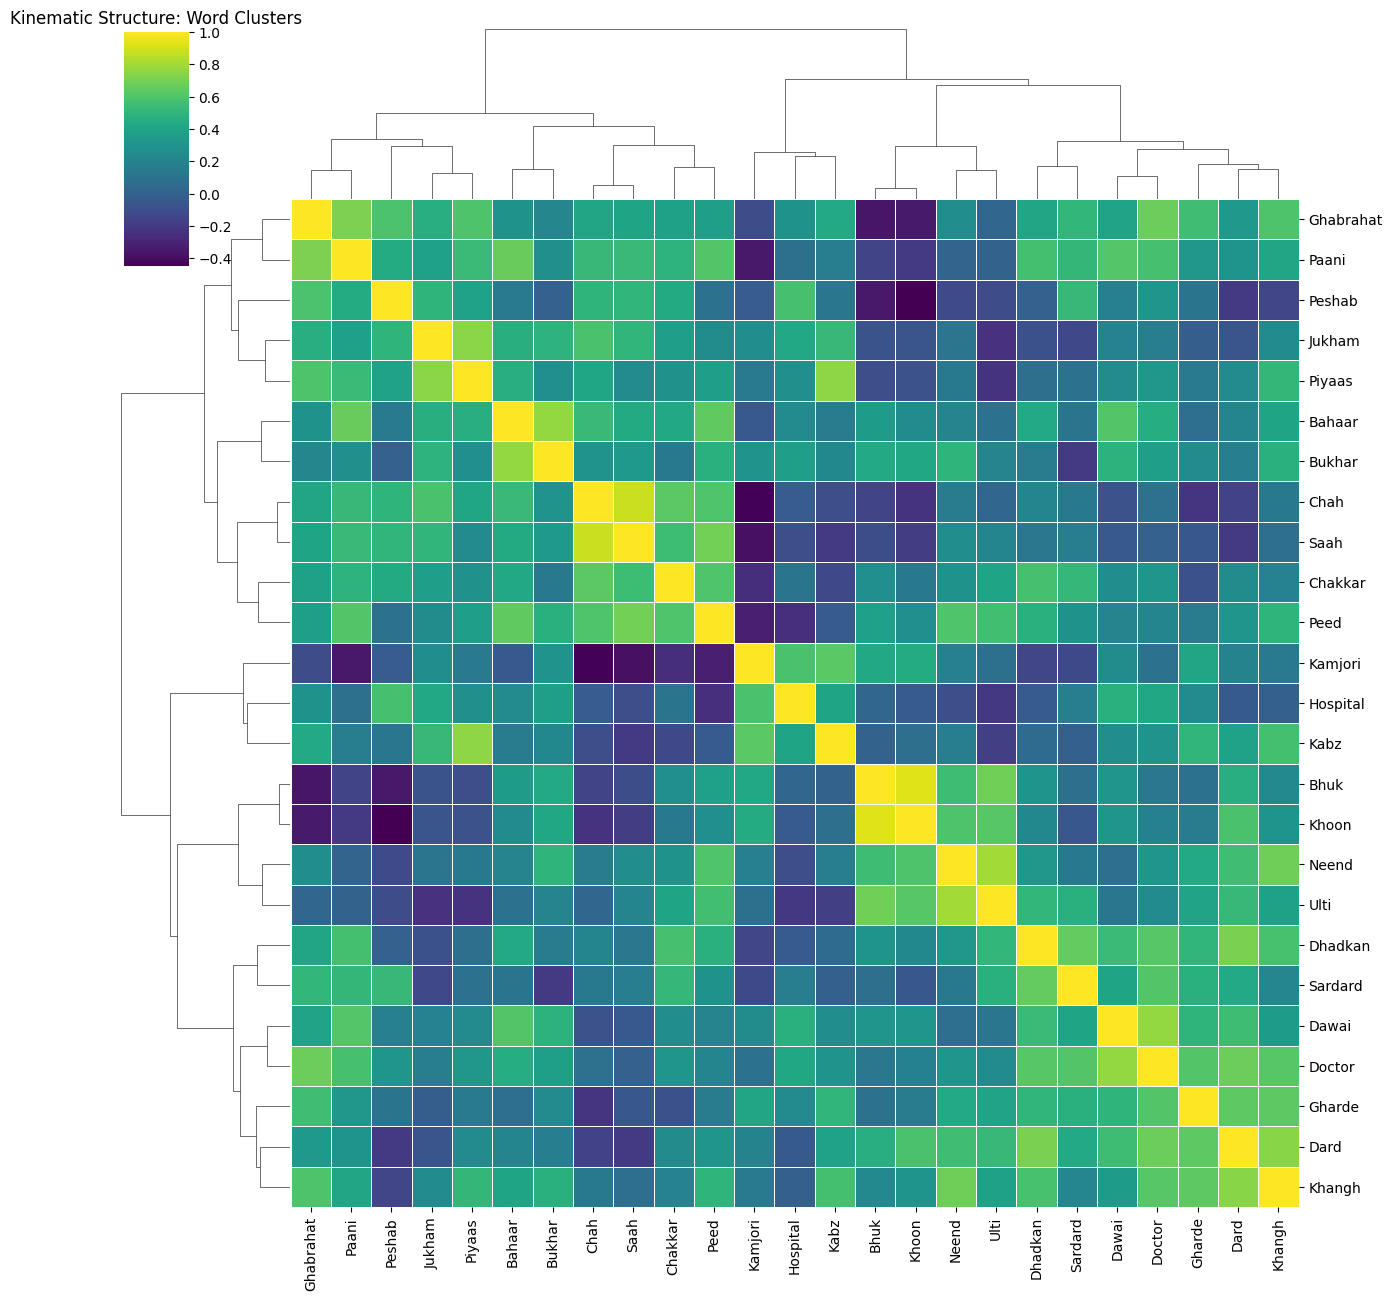

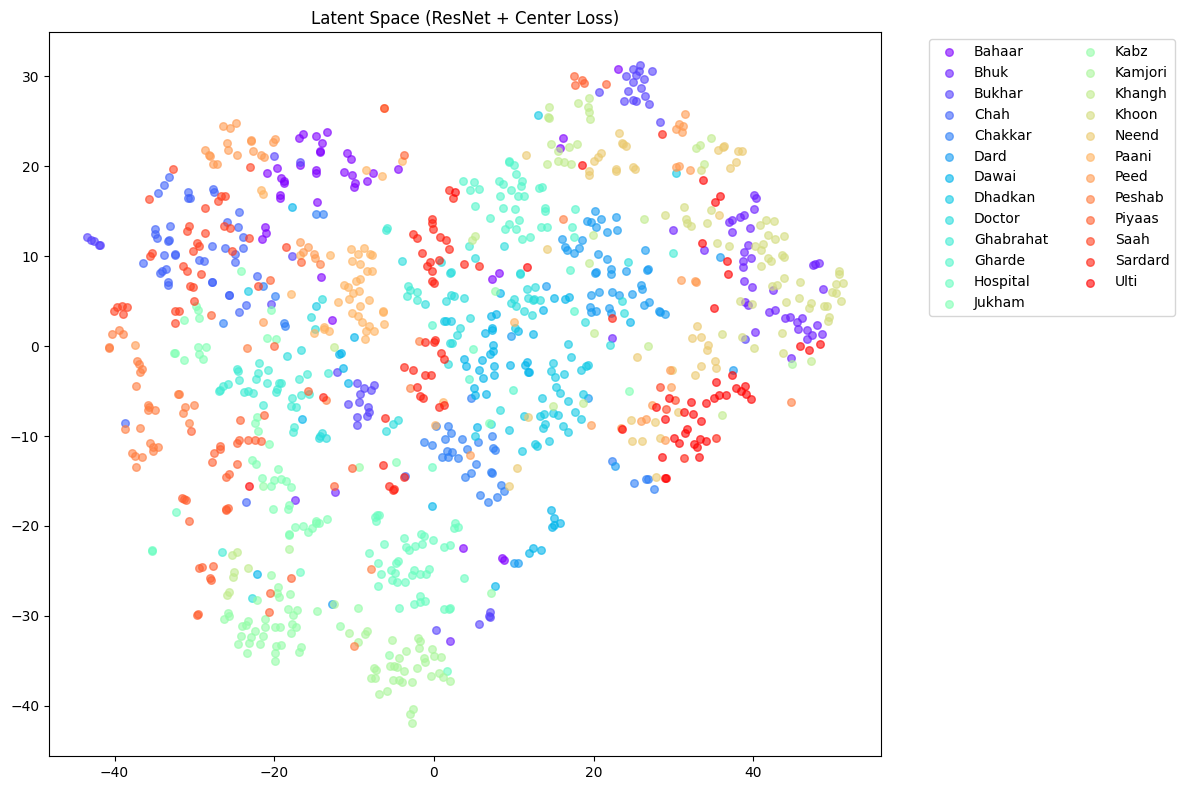

In [92]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# --- 1. CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 300 # Sequence Length
SRC_PATTERN = r'/workspace/Silent_Speech/dataset_sony/Normalized_dataset/recordings/*/*.csv'

# --- 2. ROBUST DATA LOADING (With Subject Normalization) ---
print("1. Loading & Normalizing Data...")
files = glob.glob(SRC_PATTERN)
all_sequences, all_words, all_subjects = [], [], []
features = ["theta", "x", "y", "omega", "alpha"]

for filepath in files:
    try:
        df = pd.read_csv(filepath)
        raw_data = df[features].values
        
        # Subject-Wise Normalization (Crucial for removing bias)
        subject_scaler = StandardScaler()
        norm_data = subject_scaler.fit_transform(raw_data)
        
        # Windowing
        n_chunks = len(norm_data) // T
        if n_chunks > 0:
            data_trimmed = norm_data[:n_chunks * T]
            chunks = data_trimmed.reshape(n_chunks, T, 5)
            all_sequences.append(chunks)
            
            # Metadata
            word = os.path.basename(os.path.dirname(filepath))
            subj = os.path.basename(filepath).replace('.csv', '')
            all_words.extend([word] * n_chunks)
            all_subjects.extend([subj] * n_chunks)
    except Exception as e:
        pass

X_raw = np.vstack(all_sequences) # (N, 300, 5)
print(f"   Loaded {X_raw.shape[0]} sequences.")

# Encode Labels
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(all_words)
num_classes = len(np.unique(y_numeric))
print(f"   Classes: {num_classes}")

# Create Datasets
X_tensor = torch.tensor(X_raw, dtype=torch.float32)
y_tensor = torch.tensor(y_numeric, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# --- 3. MODEL: KINEMATIC 1D-RESNET ---
class KinematicResNet(nn.Module):
    def __init__(self, input_size, num_classes, feat_dim=128):
        super(KinematicResNet, self).__init__()
        
        # CNN Backbone (Learns Local Shapes)
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        
        # Global Pooling (Summarizes the whole movement)
        self.gap = nn.AdaptiveAvgPool1d(1)
        
        # Projection Head (Latent Space)
        self.fc = nn.Linear(256, feat_dim)
        
        # Classifier
        self.classifier = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        # Permute for CNN: (Batch, Time, Channels) -> (Batch, Channels, Time)
        x = x.permute(0, 2, 1) 
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        
        x = self.gap(x).squeeze(-1) # (Batch, 256)
        
        latent = self.fc(x) # The Features for Center Loss
        logits = self.classifier(latent)
        
        return logits, latent

# --- 4. LOSS: CENTER LOSS ---
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        batch_size = features.size(0)
        # Gather the center corresponding to each sample's label
        centers_batch = self.centers.index_select(0, labels.long())
        # Calculate distance
        loss = (features - centers_batch).pow(2).sum() / 2.0 / batch_size
        return loss

# --- 5. TRAINING LOOP (Multi-Loss) ---
print("2. Initializing Research Model...")
feat_dim = 128
model = KinematicResNet(input_size=5, num_classes=num_classes, feat_dim=feat_dim).to(device)
center_loss_fn = CenterLoss(num_classes, feat_dim, device)

# Optimizers (Standard for Model, separate for Centers)
optimizer_model = optim.Adam(model.parameters(), lr=0.001)
optimizer_cent = optim.SGD(center_loss_fn.parameters(), lr=0.5) 

criterion_cls = nn.CrossEntropyLoss()

print("3. Training with Center Loss...")
for epoch in range(60):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward
        logits, features = model(x_batch)
        
        # Calculate Losses
        loss_cls = criterion_cls(logits, y_batch)
        loss_cent = center_loss_fn(features, y_batch)
        
        # Total Loss = Classification + (Lambda * Clustering)
        loss = loss_cls + 0.01 * loss_cent
        
        # Backward
        optimizer_model.zero_grad()
        optimizer_cent.zero_grad()
        loss.backward()
        
        # Update
        optimizer_model.step()
        # Important: Center Loss parameters need distinct update logic sometimes, 
        # but standard SGD step works fine for PyTorch implementation.
        optimizer_cent.step() 
        
        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    acc = 100 * correct / total
    if (epoch+1) % 10 == 0:
        print(f"   Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Acc: {acc:.2f}%")

# --- 6. ADVANCED VISUALIZATION (ClusterMap) ---
print("4. Generating Research Plots...")
model.eval()

# Extract all features
all_feats = []
all_labels = []

# Use full dataset loader
full_loader = DataLoader(dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for x_batch, y_batch in full_loader:
        _, z = model(x_batch.to(device))
        all_feats.append(z.cpu().numpy())
        all_labels.append(y_batch.numpy())

features = np.vstack(all_feats)
labels_flat = np.concatenate(all_labels)

# A. Calculate Centroids for ClusterMap
unique_labels = np.unique(labels_flat)
centroids = []
word_names = []

for label in unique_labels:
    idx = (labels_flat == label)
    centroids.append(features[idx].mean(axis=0))
    word_names.append(label_encoder.inverse_transform([label])[0])

centroids = np.array(centroids)

# B. Compute Similarity & Plot
sim_matrix = cosine_similarity(centroids)
df_sim = pd.DataFrame(sim_matrix, index=word_names, columns=word_names)

plt.figure(figsize=(12, 12))
# ClusterMap: The "Research Grade" plot
# It automatically reorders rows/cols to show clusters
sns.clustermap(df_sim, 
               method='ward', 
               metric='euclidean',
               cmap='viridis', 
               linewidths=0.5, 
               figsize=(13, 13),
               dendrogram_ratio=0.15)

plt.title("Kinematic Structure: Word Clusters")
plt.show()

# C. t-SNE for good measure
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
z_2d = tsne.fit_transform(features)

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(word_names)))
for i, word in enumerate(word_names):
    idx = (labels_flat == i)
    plt.scatter(z_2d[idx, 0], z_2d[idx, 1], label=word, s=30, alpha=0.6, color=colors[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.title("Latent Space (ResNet + Center Loss)")
plt.tight_layout()
plt.show()

1. Loading & Normalizing Data...
   Loaded 1094 samples. Classes: 25

=== PHASE A: Training Feature Extractor (Full Data) ===
   Epoch 10: Loss 3.0723
   Epoch 20: Loss 2.4838
   Epoch 30: Loss 2.1126
   Epoch 40: Loss 1.7032
   Epoch 50: Loss 1.4321
   Epoch 60: Loss 1.1404
   Epoch 70: Loss 0.9305
   Epoch 80: Loss 0.6751
   Epoch 90: Loss 0.7738
   Epoch 100: Loss 0.4192

Generating Research Plots...


<Figure size 1200x1200 with 0 Axes>

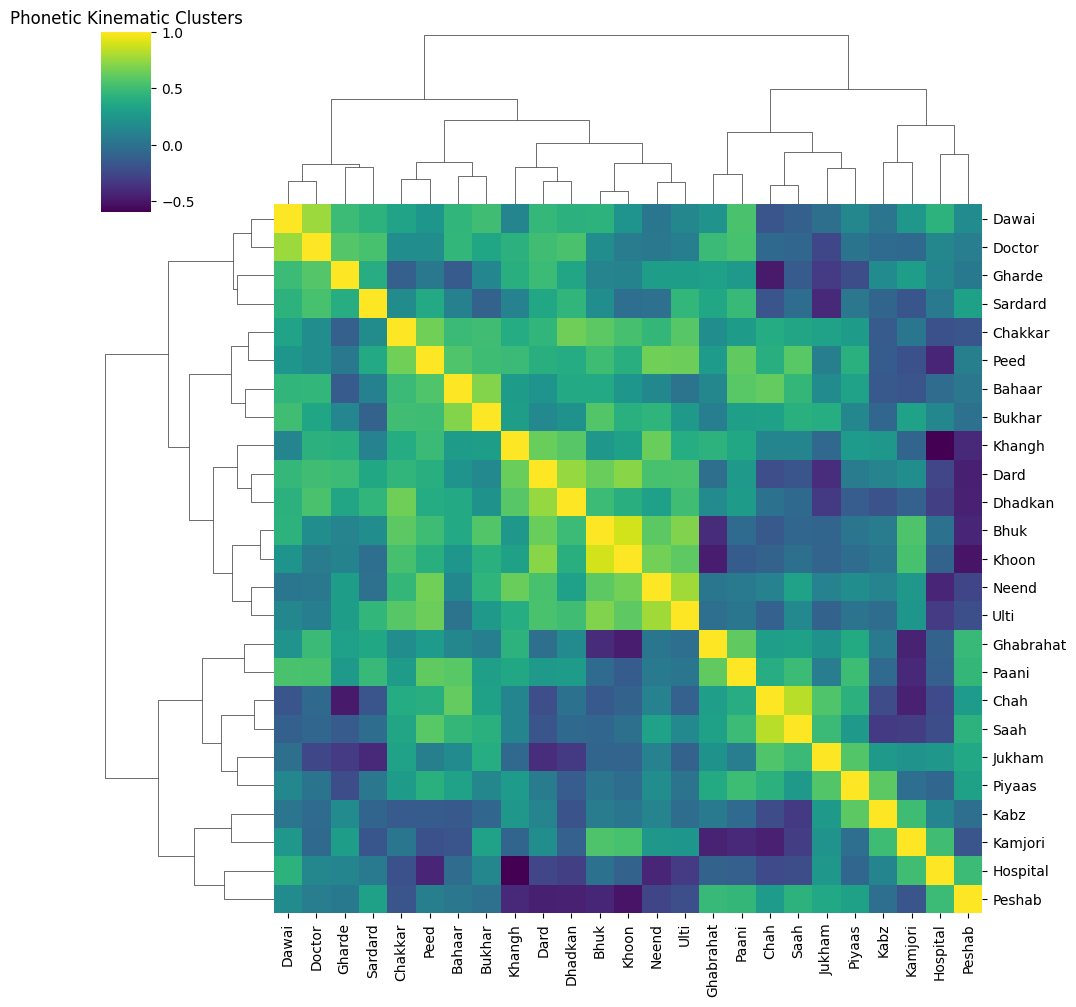


=== PHASE B: Leave-One-Subject-Out Validation (LOSO) ===
Total Subjects: 12. Running validation...
Subject: Amish      | Accuracy: 9.24%
Subject: Anupam     | Accuracy: 16.00%
Subject: Armman     | Accuracy: 9.09%
Subject: Bansbir    | Accuracy: 10.48%
Subject: Doctor     | Accuracy: 0.00%
Subject: Hospital   | Accuracy: 60.00%
Subject: Jaskaran   | Accuracy: 15.65%
Subject: KamalPreet | Accuracy: 7.89%
Subject: Surindar   | Accuracy: 6.67%
Subject: anubhavjot | Accuracy: 16.80%
Subject: harsh      | Accuracy: 13.33%
Subject: madhav     | Accuracy: 7.32%

Final LOSO Accuracy: 14.37% (+/- 14.49)


In [94]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import random

# --- 1. CONFIGURATION & REPRODUCIBILITY ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 300 # Sequence Length
SRC_PATTERN = r'/workspace/Silent_Speech/dataset_sony/Normalized_dataset/recordings/*/*.csv'

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# --- 2. DATA AUGMENTATION (TIME WARPING) ---
def augment_time_warp(tensor, sigma=0.2):
    """
    Randomly stretches or squeezes the time dimension.
    Input: (Batch, Timesteps, Channels)
    """
    batch_size, T, channels = tensor.shape
    
    # Random speed factor (e.g., 0.8x to 1.2x)
    speed = np.random.uniform(0.8, 1.2)
    new_T = int(T * speed)
    
    # Permute to (Batch, Channels, Time) for interpolation
    tensor_perm = tensor.permute(0, 2, 1)
    
    # Resize
    warped = nn.functional.interpolate(tensor_perm, size=new_T, mode='linear', align_corners=False)
    
    # Permute back to (Batch, Time, Channels)
    warped = warped.permute(0, 2, 1)
    
    # Crop or Pad to match original T
    if new_T > T:
        return warped[:, :T, :]
    else:
        pad_size = T - new_T
        return nn.functional.pad(warped, (0, 0, 0, pad_size))

# --- 3. ARCHITECTURE: SE-RESNET ---
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class KinematicResNet(nn.Module):
    def __init__(self, input_size, num_classes, feat_dim=128):
        super(KinematicResNet, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.se1 = SEBlock(64) # Attention Added
        
        # Block 2
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.se2 = SEBlock(128) # Attention Added
        
        # Block 3
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.se3 = SEBlock(256) # Attention Added
        
        # Global Pooling & Projection
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, feat_dim)
        self.classifier = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (B, T, C) -> (B, C, T)
        
        x = self.se1(self.relu(self.bn1(self.conv1(x))))
        x = self.se2(self.relu(self.bn2(self.conv2(x))))
        x = self.se3(self.relu(self.bn3(self.conv3(x))))
        
        x = self.gap(x).squeeze(-1)
        latent = self.fc(x)
        logits = self.classifier(latent)
        
        return logits, latent

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        batch_size = features.size(0)
        centers_batch = self.centers.index_select(0, labels.long())
        loss = (features - centers_batch).pow(2).sum() / 2.0 / batch_size
        return loss

# --- 4. DATA LOADING (Subject-Wise Normalization) ---
print("1. Loading & Normalizing Data...")
files = glob.glob(SRC_PATTERN)
all_sequences, all_words, all_subjects = [], [], []
features = ["theta", "x", "y", "omega", "alpha"]

for filepath in files:
    try:
        df = pd.read_csv(filepath)
        raw_data = df[features].values
        
        # Subject-Wise Norm
        subject_scaler = StandardScaler()
        norm_data = subject_scaler.fit_transform(raw_data)
        
        n_chunks = len(norm_data) // T
        if n_chunks > 0:
            data_trimmed = norm_data[:n_chunks * T]
            chunks = data_trimmed.reshape(n_chunks, T, 5)
            all_sequences.append(chunks)
            
            word = os.path.basename(os.path.dirname(filepath))
            subj = os.path.basename(filepath).replace('.csv', '')
            all_words.extend([word] * n_chunks)
            all_subjects.extend([subj] * n_chunks)
    except Exception as e:
        pass

X_raw = np.vstack(all_sequences)
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(all_words)
subjects_arr = np.array(all_subjects)
num_classes = len(np.unique(y_numeric))

X_tensor = torch.tensor(X_raw, dtype=torch.float32)
y_tensor = torch.tensor(y_numeric, dtype=torch.long)

print(f"   Loaded {len(X_raw)} samples. Classes: {num_classes}")

# --- 5. PHASE A: FULL TRAINING FOR VISUALIZATION ---
print("\n=== PHASE A: Training Feature Extractor (Full Data) ===")
# Note: We train on ALL data here purely to generate the high-quality ClusterMap
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = KinematicResNet(5, num_classes).to(device)
center_loss = CenterLoss(num_classes, 128, device)
opt_model = optim.Adam(model.parameters(), lr=0.001)
opt_cent = optim.SGD(center_loss.parameters(), lr=0.5)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    total_loss = 0
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        
        # Augmentation (Probabilistic)
        if np.random.random() > 0.5:
            x_b = augment_time_warp(x_b)
            
        logits, feats = model(x_b)
        loss = criterion(logits, y_b) + 0.01 * center_loss(feats, y_b)
        
        opt_model.zero_grad(); opt_cent.zero_grad()
        loss.backward()
        opt_model.step(); opt_cent.step()
        total_loss += loss.item()
        
    if (epoch+1) % 10 == 0:
        print(f"   Epoch {epoch+1}: Loss {total_loss/len(train_loader):.4f}")

# --- 6. VISUALIZATION (ClusterMap & t-SNE) ---
print("\nGenerating Research Plots...")
model.eval()
all_feats, all_lbls = [], []
with torch.no_grad():
    for x_b, y_b in DataLoader(dataset, batch_size=64, shuffle=False):
        _, z = model(x_b.to(device))
        all_feats.append(z.cpu().numpy())
        all_lbls.append(y_b.numpy())

features_np = np.vstack(all_feats)
labels_np = np.concatenate(all_lbls)

# Compute Centroids for ClusterMap
unique_lbls = np.unique(labels_np)
centroids, names = [], []
for lbl in unique_lbls:
    idx = (labels_np == lbl)
    centroids.append(features_np[idx].mean(axis=0))
    names.append(label_encoder.inverse_transform([lbl])[0])

sim_matrix = cosine_similarity(np.array(centroids))
df_sim = pd.DataFrame(sim_matrix, index=names, columns=names)

plt.figure(figsize=(12, 12))
sns.clustermap(df_sim, method='ward', cmap='viridis', figsize=(10, 10))
plt.title("Phonetic Kinematic Clusters")
plt.show()

# --- 7. PHASE B: SCIENTIFIC VALIDATION (LOSO) ---
print("\n=== PHASE B: Leave-One-Subject-Out Validation (LOSO) ===")
logo = LeaveOneGroupOut()
loso_accs = []
conf_matrix_accum = np.zeros((num_classes, num_classes))

# Run only first 5 folds for demonstration speed (Remove '[:5]' for full paper results)
folds = list(logo.split(X_raw, y_numeric, groups=subjects_arr))
print(f"Total Subjects: {len(folds)}. Running validation...")

for i, (train_idx, test_idx) in enumerate(folds):
    test_subj = subjects_arr[test_idx][0]
    
    # 1. Prepare Fold Data
    X_tr, X_te = X_tensor[train_idx], X_tensor[test_idx]
    y_tr, y_te = y_tensor[train_idx], y_tensor[test_idx]
    
    tr_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=32, shuffle=True)
    te_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=32, shuffle=False)
    
    # 2. Fresh Model
    fold_model = KinematicResNet(5, num_classes).to(device)
    fold_opt = optim.Adam(fold_model.parameters(), lr=0.001)
    
    # 3. Train (Short run per fold)
    for ep in range(15): 
        fold_model.train()
        for x_b, y_b in tr_loader:
            if np.random.random() > 0.5: x_b = augment_time_warp(x_b)
            fold_opt.zero_grad()
            logits, _ = fold_model(x_b.to(device))
            loss = nn.CrossEntropyLoss()(logits, y_b.to(device))
            loss.backward()
            fold_opt.step()
            
    # 4. Test
    fold_model.eval()
    correct = 0
    all_preds, all_truth = [], []
    with torch.no_grad():
        for x_b, y_b in te_loader:
            logits, _ = fold_model(x_b.to(device))
            _, pred = torch.max(logits, 1)
            correct += (pred == y_b.to(device)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_truth.extend(y_b.cpu().numpy())
            
    acc = 100 * correct / len(X_te)
    loso_accs.append(acc)
    
    # Accumulate Confusion Matrix
    cm = confusion_matrix(all_truth, all_preds, labels=range(num_classes))
    conf_matrix_accum += cm
    
    print(f"Subject: {test_subj:<10} | Accuracy: {acc:.2f}%")

print(f"\nFinal LOSO Accuracy: {np.mean(loso_accs):.2f}% (+/- {np.std(loso_accs):.2f})")

In [95]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix
import glob
import os
import random

# --- 1. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 300 # Sequence Length
SRC_PATTERN = r'/workspace/Silent_Speech/dataset_sony/Normalized_dataset/recordings/*/*.csv'

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

# --- 2. DATA LOADING (Logical Features: dx, dy) ---
print("1. Loading Data & Computing Velocities...")
files = glob.glob(SRC_PATTERN)
all_sequences, all_words, all_subjects = [], [], []

for filepath in files:
    try:
        df = pd.read_csv(filepath)
        
        # LOGICAL INPUTS: Velocity (dx, dy) and Angle (theta)
        # We drop absolute 'x' and 'y' to prevent overfitting to face size.
        df['dx'] = df['x'].diff().fillna(0)
        df['dy'] = df['y'].diff().fillna(0)
        
        features = df[['theta', 'omega', 'alpha', 'dx', 'dy']].values
        
        # Windowing
        n_chunks = len(features) // T
        if n_chunks > 0:
            data_trimmed = features[:n_chunks * T]
            chunks = data_trimmed.reshape(n_chunks, T, 5)
            
            # Local Normalization (Scale each window independently)
            for i in range(len(chunks)):
                scaler = StandardScaler()
                chunks[i] = scaler.fit_transform(chunks[i])
            
            all_sequences.append(chunks)
            
            # Metadata
            word = os.path.basename(os.path.dirname(filepath))
            subj = os.path.basename(filepath).replace('.csv', '')
            all_words.extend([word] * n_chunks)
            all_subjects.extend([subj] * n_chunks)
            
    except Exception as e:
        pass

X_raw = np.vstack(all_sequences)
X_tensor = torch.tensor(X_raw, dtype=torch.float32)

label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(all_words)
y_tensor = torch.tensor(y_numeric, dtype=torch.long)
subjects_arr = np.array(all_subjects)
num_classes = len(np.unique(y_numeric))

print(f"   Samples: {len(X_raw)} | Features: [theta, omega, alpha, dx, dy]")

# --- 3. MODEL: SimpleCNN Feature Extractor ---
class SimpleCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Feature Extraction Block (The "Latent" Generator)
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv1d(input_size, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2), # Downsample 300 -> 150
            
            # Layer 2
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2), # Downsample 150 -> 75
            
            # Layer 3
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1) # Crunch everything into 1 vector
        )
        
        # Classifier Head (We only use this for training)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Permute: (Batch, Time, Chan) -> (Batch, Chan, Time)
        x = x.permute(0, 2, 1)
        
        # Extract Features
        latent_vector = self.features(x)
        latent_vector = latent_vector.view(latent_vector.size(0), -1) # Flatten (Batch, 128)
        
        # Classify
        logits = self.classifier(latent_vector)
        
        return logits, latent_vector # Return BOTH

# --- 4. TRAINING & VALIDATION ---
print("\n2. Starting LOSO Validation...")
logo = LeaveOneGroupOut()
loso_accs = []

# We iterate through subjects to validate
for i, (train_idx, test_idx) in enumerate(logo.split(X_raw, y_numeric, groups=subjects_arr)):
    test_subj = subjects_arr[test_idx][0]
    
    # Split
    X_tr, X_te = X_tensor[train_idx], X_tensor[test_idx]
    y_tr, y_te = y_tensor[train_idx], y_tensor[test_idx]
    
    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=32, shuffle=False)
    
    # Fresh Model
    model = SimpleCNN(input_size=5, num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Train
    for epoch in range(20):
        model.train()
        for x_b, y_b in train_loader:
            optimizer.zero_grad()
            logits, _ = model(x_b.to(device)) # We ignore features during training
            loss = criterion(logits, y_b.to(device))
            loss.backward()
            optimizer.step()
            
    # Test
    model.eval()
    correct = 0
    with torch.no_grad():
        for x_b, y_b in test_loader:
            logits, _ = model(x_b.to(device))
            _, preds = torch.max(logits, 1)
            correct += (preds == y_b.to(device)).sum().item()
            
    acc = 100 * correct / len(X_te)
    loso_accs.append(acc)
    print(f"Subject: {test_subj:<12} | Accuracy: {acc:.2f}%")

print(f"\nMean Accuracy: {np.mean(loso_accs):.2f}%")

# --- 5. EXTRACT FEATURES FOR CLUSTERING (OPTIONAL) ---
# If you want to plot the clusters now using the best model:
print("\n3. Extracting Features from Full Dataset...")
full_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=False)
all_features = []
all_labels = []

model.eval()
with torch.no_grad():
    for x_b, y_b in full_loader:
        _, features = model(x_b.to(device))
        all_features.append(features.cpu().numpy())
        all_labels.append(y_b.numpy())

final_features = np.vstack(all_features)
print(f"Extracted Feature Shape: {final_features.shape}")
# You can now feed 'final_features' into t-SNE or Dendrogram code

1. Loading Data & Computing Velocities...
   Samples: 1094 | Features: [theta, omega, alpha, dx, dy]

2. Starting LOSO Validation...
Subject: Amish        | Accuracy: 9.24%
Subject: Anupam       | Accuracy: 12.00%
Subject: Armman       | Accuracy: 3.03%
Subject: Bansbir      | Accuracy: 11.29%
Subject: Doctor       | Accuracy: 20.00%
Subject: Hospital     | Accuracy: 40.00%
Subject: Jaskaran     | Accuracy: 6.09%
Subject: KamalPreet   | Accuracy: 5.26%
Subject: Surindar     | Accuracy: 8.33%
Subject: anubhavjot   | Accuracy: 7.20%
Subject: harsh        | Accuracy: 14.17%
Subject: madhav       | Accuracy: 6.50%

Mean Accuracy: 11.93%

3. Extracting Features from Full Dataset...
Extracted Feature Shape: (1094, 128)
